<img src="../../Img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>

DIGHUM160 - Critical Digital Humanities<br>
Digital Hermeneutics<br>
Week 5-2: Sentiment Analysis<br>
Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)

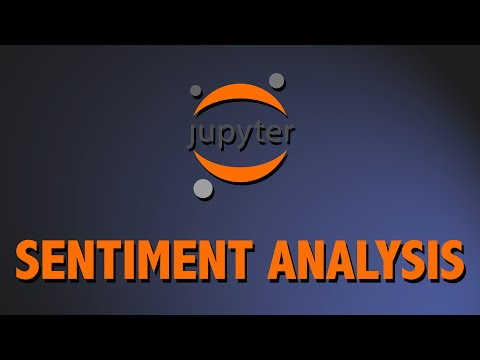

In [21]:
# Please run this cell for the accompanying video.
from IPython.display import YouTubeVideo
YouTubeVideo('wkpY_l8VV6Q', width=640, height=360)

## Automated sentiment analysis using NLTK VADER

This notebook covers basic sentiment analysis (sometimes known as "opinion mining"). The most common use of sentiment analysis is to classify text (called "sentiment classification"). We'll get to that further on. First, let's see how sentiment analysis itself works.

The simplest option is to use pre-built libraries for sentiment analysis. TextBlob and NLTK VADER are two examples of such libraties. VADER (Valence Aware Dictionary and sEntiment Reasoner) is specifically built for social media texts, and takes multiple text features into account, such as:

- **Punctuation** (e.g. an exclamation mark "!" increases the magnitude of intensity)
- **Capitalization** (e.g. "The food here is GREAT" is more intense than "The food here is great")
- **Degree modifiers** (e.g. "The service here is extremely good" is more intense than "The service here is good")
- **Conjunctions** signal a shift in sentiment polarity, with the sentiment of the text following the conjunction being dominant (e.g. “The food here is great, but the service is horrible”)
- **Preceding Tri-grams** of a sentiment-laden lexical feature catch 90% of cases where negation flips the polarity of the text (e.g. "The food here isn’t really all that great”)
- **Emoji, emoticons & slang** are parsed very well by VADER.

In [4]:
import nltk
from nltk import FreqDist
from nltk.classify import apply_features
from nltk.corpus import stopwords
from nltk.classify import accuracy
from nltk import NaiveBayesClassifier
from nltk.metrics import precision as prec
from nltk.metrics import recall as rec
from nltk.metrics import f_measure as fmeas
nltk.download('stopwords')
nltk.download('punkt') 

# VADER - installing using magic command `!pip install vaderSentiment` (command line script)
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomvannuenen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tomvannuenen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import os
# We include two ../ because we want to go two levels up in the file structure
os.chdir("../../Data")

In [7]:
import pandas as pd 

# importing file in df
df = pd.read_csv('aita_sub_top_sm_lemmas.csv')
len(df)

16310

In [9]:
# instantiate Class
analyser = SentimentIntensityAnalyzer()

In [10]:
# a small test
analyser.polarity_scores("""This is really dumb. I don't want to use this stupid 
                          program.""")

{'neg': 0.495, 'neu': 0.505, 'pos': 0.0, 'compound': -0.8323}

VADER spits out several metrics we can use. The **Positive**, **Negative** and **Neutral** scores represent the proportion of text that falls in these categories. This means our sentence was rated as 0% Positive, 50% Neutral and 50% Negative. All these add up to 1.

The **Compound** score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive). The compound score turns out to be -.83: a pretty negative sentiment overall. Let's use that score for now (but be aware that you can use these `neg`, `neu` and `pos` scores to your advantage to train a more precise classifier!)

Now let's write a function that takes a text in, and spits out one of 3 tags based on the compound score. We first use `sent_tokenize` to split sentences, get the compound sentiment score for each sentence, and finally get the average of these scores.

In [11]:
from nltk.tokenize import sent_tokenize

def sentiment_analyzer_scores(text):
    sents = sent_tokenize(text)
    temp_li = []
    for sent in sents:
        x = analyser.polarity_scores(sent)
        temp_li.append(x['compound'])
    avg = sum(temp_li) / len(temp_li)
      # decide sentiment as positive, negative and neutral 
    if avg >= 0.05 : 
        tag = "pos"
    elif avg <= - 0.05 : 
        tag = "neg"
    else : 
        tag = "neut" 
    return [tag, avg]

Let's append the output to 2 new columns in our dataframe. `.apply()` allows us to apply a function along an axis of the DataFrame. Also note the use of `zip()` here, allowing us to map the 2 returned values of our function to the tuple of variables we assign them to. Finally, note the `*` to unpack these containers.

In [14]:
df["sent"], df["sent_compound"] = zip(*df.selftext.apply(sentiment_analyzer_scores))

Let's have a look:

In [16]:
df.sent.value_counts()

pos     6415
neut    5296
neg     4599
Name: sent, dtype: int64

In [17]:
df.head()

,idint,idstr,created,nsfw,author,title,selftext,lemmas,score,distinguish,textlen,num_comments,flair_text,flair_css_class,sent,sent_compound
0,427576402,t3_72kg2a,1506433689,0.0,Ritsku,AITA for breaking up with my girlfriend becaus...,My girlfriend recently went to the beach with ...,girlfriend recently beach friend tiny bikini b...,679.0,NaN,4917.0,434.0,no a--holes here,NaN,neut,-0.042952
1,551887974,t3_94kvhi,1533404095,0.0,hhhhhhffff678,AITA for banning smoking in my house and telli...,My parents smoke like chimneys. I used to as w...,parent smoke like chimney use quit wife young ...,832.0,NaN,2076.0,357.0,asshole,ass,neut,0.022829
2,552654542,t3_951az2,1533562299,0.0,creepatthepool,AITA? Creep wears skimpy bathing suit to pool,Hi guys. Throwaway for obv reasons.\n\nI'm a f...,hi guy throwaway obv reason i'm female child b...,23.0,NaN,1741.0,335.0,Shitpost,NaN,neut,-0.048050
3,556350346,t3_978ioa,1534254641,0.0,Pauly104,AITA for eating steak in front of my vegan GF?,"Yesterday night, me and my GF decided to go ou...",yesterday night gf decide eat vegan day vegan ...,1011.0,NaN,416.0,380.0,not the a-hole,not,neut,-0.035217
4,560929656,t3_99yo3c,1535126620,0.0,ThatSpencerGuy,AITA for not wanting to cook my mother-in-law ...,"My wife and I are vegetarians, much to my in-l...",wife vegetarian law vocal annoyance year visit...,349.0,NaN,1158.0,360.0,not the a-hole,not,pos,0.114105


array([[<AxesSubplot:title={'center':'sent_compound'}>]], dtype=object)

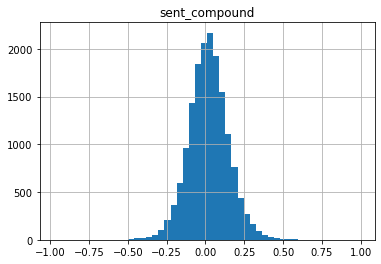

In [18]:
df.hist(column="sent_compound",bins=50)

Let's see if these scores make sense. We'll print out the comment with the lowest score (note: we could also use `.idxmax()` to find the comment with the highest score). 

In [20]:
min_id = df.sent_compound.idxmin()
df.selftext[min_id]

'So this happened today, we have to make a project with a group where they give us a theme for a debate we have to do, some people got abortion, homoparenting, inmigration, debatable stuff, but our group got anti vaxxers and we have to be on their side, and let me tell you that being on the internet and have myself investigate the safety of vaccinations for 3 months is not in my fucking favor, im just so angry of adding this as a theme for a fucking debate, I inmediately told the teacher it was unfair and she told me that I just had to look up the information, 30 minutes in and no one of my group gets anything helping our case, then the teacher tries for 20 minutes and also gets nothing, at the end, the teacher tell us that we still have to do it and that if we dont find anything we just lie (WICH IS SOMETHING THEY TOLD US NOT TO DO) and im just fucking pissed, I dont want to do this because its so easy to tear apart any of the arguments of anti vaxxers, basically Im fucked and me and 

That does look like a comment with lots of negative language. However, we should keep in mind that the language communities we are looking at often use highly specific vocabularies; as such, a pretrained sentiment analysis algorithm will not always be very precise. Further, misspellings and grammatical mistakes may cause the analysis to overlook important words or usage, and sarcasm and irony may be easily misinterpreted.

## Working with sentiment scores

You could use these sentiment scores for all kinds of purposes. 

First, you could look at comments with a high or low sentiment, and see what kinds of topics or concerns are discussed. 

You could train a Naive Bayes classifier (using the code we used above) to see whether sentiments in the posts tell you anything about what `flair_text` class that post falls under. You could also run a **regression analysis** to see if a post's sentiment score (X) is a predictor for something like the user score it received (y). Please see the additional notebook, I will share, "5-X Regression", if you're interested in that.

You could also combine it with your **topic modeling** output, if that output is interesting. You could create a column in your DataFrame that tells you the most-associated topic with each post/comment (using the notebook from week 3), then see if certain topics relate to certain sentiments.